In [1]:
%matplotlib inline

import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
import albumentations as A
import argparse
import matplotlib.pyplot as plt
import numpy as np
import cv2
from torch.utils.data import DataLoader
from albumentations.pytorch import ToTensorV2
from os.path import abspath, join, dirname
from tqdm import tqdm

sys.path.append(os.path.abspath(os.path.join("..", "unet")))
from dataset import COCODataset

WIDTH = 256
HEIGHT = 256
BATCH_SIZE = 9

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"DEVICE: {device}")

C:\Users\danie\.virtualenvs\BoneSegmentation-dpCXn3BL\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DEVICE: cuda:0


In [2]:
image_path = "D:\\Datasets\\Segmentation\\COCO\\val2017"
mask_path = "D:\\Datasets\\Segmentation\\COCO\\masks\\val2017"

params = {
    "batch_size": BATCH_SIZE,
    "shuffle": False,
    "num_workers": 1
}

In [3]:
transform = A.Compose(
    [
        A.Resize(height=int(HEIGHT*1.13), width=int(WIDTH*1.13)),
        A.RandomCrop(height=HEIGHT, width=WIDTH),
        A.Rotate(limit=90, p=0.9),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.CLAHE(clip_limit=4.0, p=0.35),
        A.ColorJitter(p=0.3),
        A.GaussNoise(p=0.3),
#         A.Normalize(
#             mean=[103.6788, 113.7296, 119.6984],
#             std=[72.6042, 68.8787, 70.1635],
#             max_pixel_value=255.0
#         ),
        ToTensorV2()
    ]
)

cocodata = COCODataset(image_path, mask_path, transform=transform)
cocoloader = DataLoader(cocodata, **params)

# Mean: tensor([103.6788, 113.7296, 119.6984]), Std: tensor([72.6042, 68.8787, 70.1635])
# mean, std = cocodata.get_dataset_mean_and_std(cocoloader)
# print(f"Mean: {mean}, Std: {std}")

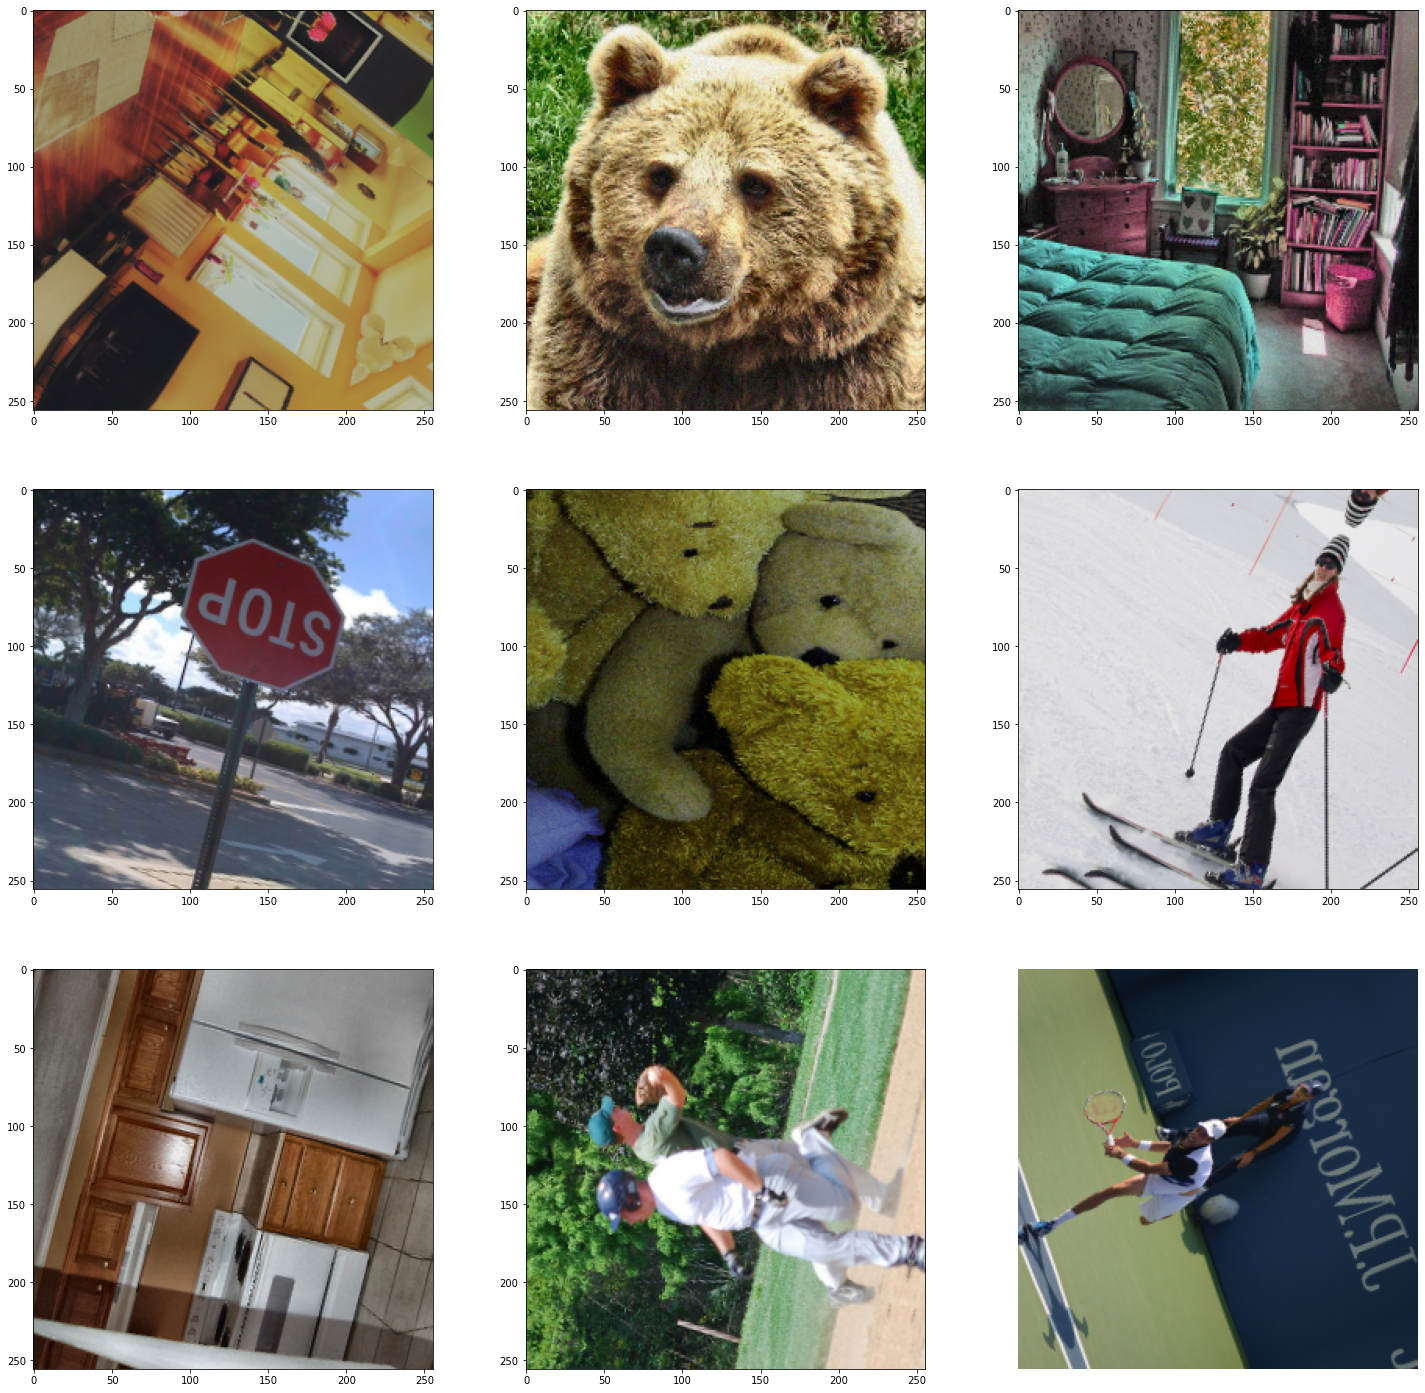

In [4]:
data, targets = next(iter(cocoloader))
# print(data[2].shape)
ax_size = BATCH_SIZE**0.5
assert ax_size.is_integer() # make sure batch size perfect square
ax_size = int(ax_size)

f, axarr = plt.subplots(ax_size, ax_size, figsize=(25,25))
count = 0
for i in range(ax_size):
    for j in range(ax_size):
        fig_img = torch.moveaxis(data[count], 0, -1).int()
        axarr[i,j].imshow(fig_img)
        plt.axis("off")
        count += 1
